# Basic time series exploration

In [2]:
from time_series_expenses.prepare_data import monthly

## Creating a Prophet model

In [3]:
monthly.head()

,y,ds
Date,,
2021-10-01,659.76,2021-10-01
2021-11-01,840.82,2021-11-01
2021-12-01,378.26,2021-12-01
2022-01-01,825.94,2022-01-01
2022-02-01,551.60,2022-02-01


In [4]:
from prophet import Prophet
model = Prophet()

model.fit(monthly)

12:30:47 - cmdstanpy - INFO - Chain [1] start processing
12:30:47 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# Predict next year
future = model.make_future_dataframe(periods = 12, freq = "MS")
forecast = model.predict(future)[["ds", "yhat", "yhat_lower", "yhat_upper"]]

forecast.tail(13)

,ds,yhat,yhat_lower,yhat_upper
29,2024-03-01,952.140845,718.571763,1184.149406
30,2024-04-01,1028.470628,802.534264,1265.148421
31,2024-05-01,1599.482397,1355.860285,1832.645373
32,2024-06-01,147.252904,-97.488430,378.279862
33,2024-07-01,1856.977252,1623.321569,2094.359462
34,2024-08-01,2533.920093,2300.307025,2784.564466
35,2024-09-01,1278.637344,1032.529813,1521.660022
36,2024-10-01,1686.821793,1456.405456,1918.044335
37,2024-11-01,906.759824,660.144675,1147.122920
38,2024-12-01,1415.911314,1176.500669,1652.949851


c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


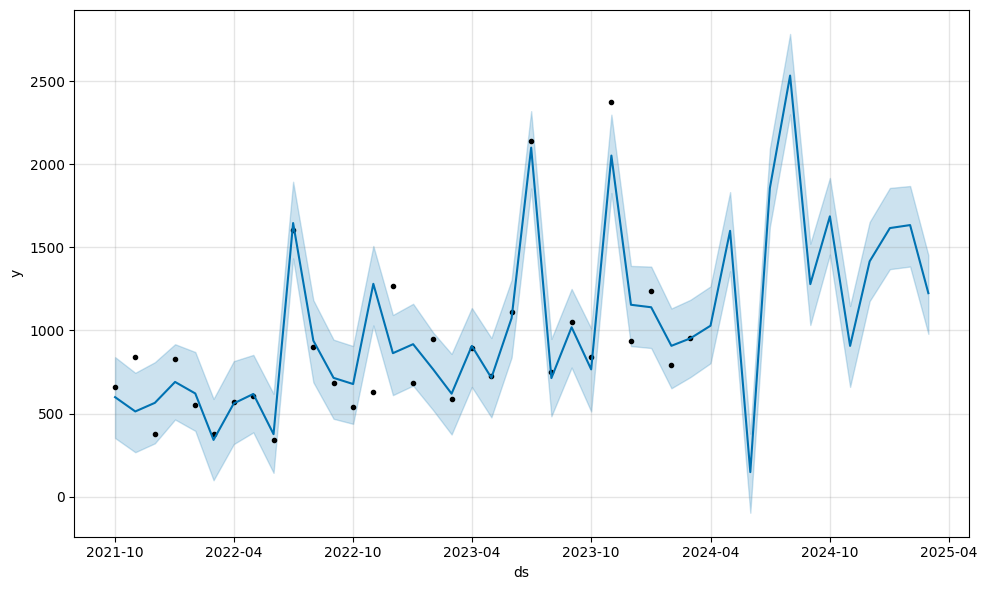

In [6]:
# Automatic plotting of a given dataframe
figure1 = model.plot(forecast)

## Metrics

In [7]:
from time_series_expenses.forecast_metrics import create_metrics_df
original_metrics = create_metrics_df(monthly, forecast)

In [8]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print(r2_score(original_metrics.y, original_metrics.yhat))
print(mean_squared_error(original_metrics.y, original_metrics.yhat))
print(f"MAE: {mean_absolute_error(original_metrics.y, original_metrics.yhat)}")


0.8312310851033843
35071.712239610824
MAE: 120.55250166282562


In [9]:
# Interactive plot
# For monthly data, 1month and 1week, components in general not available
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model, forecast)

Saturating forecasts - minimums and maximums

In [10]:
# We need to add an additional column to the dataframe - cap for maximum, floor for minimum, and pass that to the model
monthly["floor"] = 0

# A cap is NEEDED, not optional. Floor is optional.

# Arbitrarily high cap:
monthly["cap"] = 10000
monthly.tail()

,y,ds,floor,cap
Date,,,,
2023-11-01,2373.00,2023-11-01,0,10000
2023-12-01,937.80,2023-12-01,0,10000
2024-01-01,1235.74,2024-01-01,0,10000
2024-02-01,789.50,2024-02-01,0,10000
2024-03-01,952.70,2024-03-01,0,10000


In [11]:
model_logistic = Prophet(growth = "logistic")
model_logistic.fit(monthly)

12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
future = model_logistic.make_future_dataframe(periods = 12, freq = "MS")
future["cap"] = 10000
future["floor"] = 0
future.tail()

,ds,cap,floor
37,2024-11-01,10000,0
38,2024-12-01,10000,0
39,2025-01-01,10000,0
40,2025-02-01,10000,0
41,2025-03-01,10000,0


c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



(0.0, 3000.0)

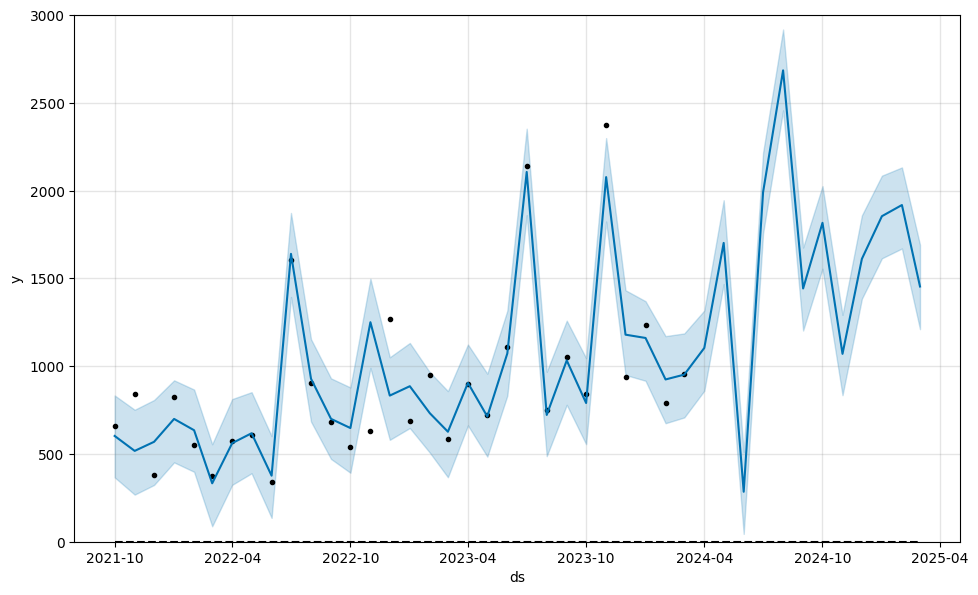

In [13]:
forecast2 = model_logistic.predict(future)
fig_logistic = model_logistic.plot(forecast2)

# Set the axis to not stretch to 10000
axes = fig_logistic.gca()
axes.set_ylim([0, 3000])

## Cross validation

In [14]:
monthly_model = Prophet(yearly_seasonality= True, weekly_seasonality= False, daily_seasonality=False)
# Info for monthly seasonality: https://stackoverflow.com/a/71810822/21445669
monthly_model.add_seasonality(
    name = "monthly",
    period = 30.5,
    fourier_order= 5
)
monthly_model.fit(monthly)

12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
# Predict next year
future = monthly_model.make_future_dataframe(periods = 12, freq = "MS")
forecast = monthly_model.predict(future)[["ds", "yhat", "yhat_lower", "yhat_upper"]]

forecast.tail(13)

,ds,yhat,yhat_lower,yhat_upper
29,2024-03-01,956.337524,756.321692,1154.294631
30,2024-04-01,2436.708479,2250.154354,2639.622884
31,2024-05-01,1386.028316,1195.113488,1572.764027
32,2024-06-01,1216.527989,1001.307768,1402.787104
33,2024-07-01,1287.025440,1095.826301,1478.997886
34,2024-08-01,3333.430511,3130.888153,3523.174067
35,2024-09-01,2153.353838,1955.833628,2352.842197
36,2024-10-01,2324.469344,2127.506872,2504.844087
37,2024-11-01,1214.924548,1013.850879,1403.953633
38,2024-12-01,2111.664311,1917.507763,2305.977252


c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



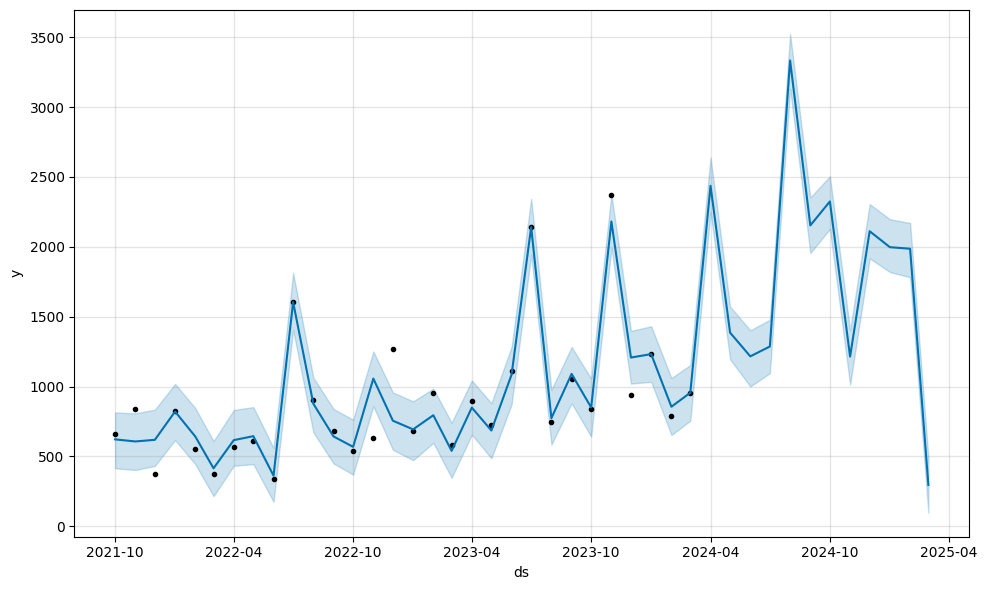

In [16]:
# Automatic plotting of a given dataframe
figure2 = monthly_model.plot(forecast)

In [17]:
metrics_df = create_metrics_df(monthly, forecast)

metrics_df.head()

,yhat,y
ds,,
2021-10-01,622.551653,659.76
2021-11-01,607.686198,840.82
2021-12-01,619.206352,378.26
2022-01-01,821.770109,825.94
2022-02-01,642.944763,551.60


In [18]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

print(r2_score(metrics_df.y, metrics_df.yhat))
print(mean_squared_error(metrics_df.y, metrics_df.yhat))
print(f"RMSE: {root_mean_squared_error(metrics_df.y, metrics_df.yhat)}")
print(f"MAE: {mean_absolute_error(metrics_df.y, metrics_df.yhat)}")


0.8847150003149764
23957.269245782478
RMSE: 154.78135949067794
MAE: 90.22034537211695


In [19]:
monthly.tail()

,y,ds,floor,cap
Date,,,,
2023-11-01,2373.00,2023-11-01,0,10000
2023-12-01,937.80,2023-12-01,0,10000
2024-01-01,1235.74,2024-01-01,0,10000
2024-02-01,789.50,2024-02-01,0,10000
2024-03-01,952.70,2024-03-01,0,10000


In [20]:
# Implementing monthly CV: https://github.com/facebook/prophet/issues/1672

# Forecast horizon: 1 year
# Period for walking through cross-validation: 3 months
import pandas as pd
# Start date -- minimum observed + training period. Here set to 1 year
# Ending = last observed data point - forecast horizon duration
cutoff_dates = pd.date_range(start="2023-01-01", end = "2023-03-01", freq="1MS")

In [21]:
from prophet.diagnostics import cross_validation

cross_validated = cross_validation(model = monthly_model,
                                   horizon = "365 days",
                                   cutoffs = cutoff_dates,
                                   # Parallel computing
                                   parallel="processes")
cross_validated

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-02-01,80.043821,78.415881,81.614063,951.44,2023-01-01
1,2023-03-01,1279.127387,1273.937124,1284.287003,585.24,2023-01-01
2,2023-04-01,3361.307814,3351.734053,3370.988446,896.00,2023-01-01
3,2023-05-01,337.758694,322.362040,353.304778,724.44,2023-01-01
4,2023-06-01,-55.750946,-77.531453,-33.151871,1108.14,2023-01-01
5,2023-07-01,4526.206046,4497.616522,4556.279883,2142.70,2023-01-01
6,2023-08-01,-544.710091,-580.855510,-505.205595,748.90,2023-01-01
7,2023-09-01,7119.674309,7076.667237,7168.412489,1052.40,2023-01-01
8,2023-10-01,708.795147,657.101695,765.999594,842.60,2023-01-01
9,2023-11-01,2163.422285,2103.409548,2230.727348,2373.00,2023-01-01


In [22]:
# raw perfomance metrics - all rows

print(r2_score(cross_validated.y, cross_validated.yhat))
print(mean_squared_error(cross_validated.y, cross_validated.yhat))
print(f"RMSE: {root_mean_squared_error(cross_validated.y, cross_validated.yhat)}")
print(f"MAE: {mean_absolute_error(cross_validated.y, cross_validated.yhat)}")

-17.625172814624534
5359245.378025328
RMSE: 2315.004401297183
MAE: 1670.510370897913


In [25]:
from prophet.diagnostics import performance_metrics
performance_metrics(cross_validated, rolling_window=1) # Same as above, all rows combined

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,365 days,5.359245e+06,2315.004401,1670.510371,1.743993,0.915871,0.890061,0.0


In [31]:
performance_metrics(cross_validated, rolling_window=0.5)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,181 days,6.597645e+06,2568.588038,1962.655619,2.163177,1.112384,0.992938,0.0
1,184 days,5.462148e+06,2337.123937,1721.356605,1.737402,1.050310,0.919689,0.0
2,212 days,5.586421e+06,2363.561048,1800.022414,1.834361,1.112384,0.964070,0.0
3,214 days,5.312512e+06,2304.888814,1712.656863,1.726302,1.057028,0.938429,0.0
4,242 days,5.392710e+06,2322.220883,1749.456766,1.765602,1.057028,0.949693,0.0
5,243 days,7.557435e+06,2749.078924,2100.049646,2.096026,1.112384,1.028935,0.0
6,245 days,6.274213e+06,2504.837887,1921.105238,1.732557,1.057028,1.027867,0.0
7,273 days,5.904210e+06,2429.857946,1772.141532,1.556013,1.050310,0.931543,0.0
8,275 days,5.597082e+06,2365.815300,1727.405440,1.522470,1.057028,0.920963,0.0
9,303 days,6.226765e+06,2495.348629,1854.235915,1.671872,1.057028,0.944103,0.0
